In [1]:
import torch
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, FloatSlider, IntSlider
from torch_transform_image import (
    affine_transform_image_2d, 
    affine_transform_image_3d, 
    rotate_then_shift_image_2d, 
    shift_then_rotate_image_2d, 
    rotate_then_shift_image_3d,
    shift_then_rotate_image_3d,
)

In [2]:
def master_plot_function(
        volume: torch.Tensor, 
        gray_min: float | None = None, 
        gray_max: float | None = None,
        gray_mid: float | None = None,
):
    gray_min = volume.min().item() if gray_min is None else gray_min
    gray_max = volume.max().item() if gray_max is None else gray_max
    gray_mid = (gray_min + gray_max) / 2 if gray_mid is None else gray_mid

    plane_min = 0
    plane_max = volume.shape[2] - 1
    plane_mid = int(plane_max / 2) 

    # Wrapped function that captures the volume tensor
    def plot_wrapper(zmin, zplane):
        fig = go.Figure(
            data=go.Heatmap(
                z=volume[:, :, zplane],
                colorscale="viridis",
                zmin=zmin,
                zmax=volume.max().item(),
            )
        )
        fig.update_layout(
            title=f"Slice {zplane} with threshold zmin={zmin:.2f}", width=800, height=600
        )
        return fig

    interact(
        plot_wrapper,
        zmin=FloatSlider(
            min=gray_min,
            max=gray_max,
            step=(gray_max - gray_min) / 100,
            value=gray_mid,
            description="Threshold:",
            continuous_update=True,
        ),
        zplane=IntSlider(
            min=plane_min,
            max=plane_max,
            step=1,
            value=plane_mid,
            description="Plane:",
            continuous_update=True,
        ),
    )

In [3]:
image = torch.zeros((28, 28, 28), dtype=torch.float32)
image[0, 0, 13] = 1
image = image.float()

In [4]:
max_idx = torch.nonzero(image == image.max())
print("Location(s) of maximum value in result:", max_idx.tolist())
master_plot_function(image)

Location(s) of maximum value in result: [[0, 0, 13]]


interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), IntSlider(value=13…

## Shift

In [5]:
result = rotate_then_shift_image_3d(
    image=image,
    rotate_xyz=[0, 0, 0],
    shifts_xyz=[5, 0, 0],
    interpolation="trilinear",
)
max_idx = torch.nonzero(result == result.max())
print("Location(s) of maximum value in result:", max_idx.tolist())
print(result[5,0,13])
master_plot_function(result)

Location(s) of maximum value in result: [[5, 0, 13]]
tensor(1.)


interactive(children=(FloatSlider(value=0.5, description='Threshold:', max=1.0, step=0.01), IntSlider(value=13…

## Rotation 

In [6]:
image = torch.zeros((28, 28, 28), dtype=torch.float32)
image[12, 10, 13] = 1
image = image.float()

In [7]:
accum = torch.zeros_like(image)
for a in range(0,360,10):
    result = rotate_then_shift_image_3d(
        image=image,
        rotate_xyz=[0, 0, a],
        shifts_xyz=[0, 0, 0],
        interpolation="trilinear",
    )
    accum += result
max_idx = torch.nonzero(result == result.max())
print("Location(s) of maximum value in result:", max_idx.tolist())
master_plot_function(accum, gray_mid=0)

Location(s) of maximum value in result: [[13, 10, 13]]


interactive(children=(FloatSlider(value=0.0, description='Threshold:', max=1.3949881792068481, step=0.01394988…

## Comparing to direct T transformation

In [8]:
from torch_transform_image import affine_transform_image_3d
from torch_affine_utils.transforms_3d import T

In [9]:
image = torch.zeros((28, 28, 28), dtype=torch.float32)
image[0, 0, 13] = 1
image = image.float()

In [10]:
s = [5,0,0]

In [11]:
result = rotate_then_shift_image_3d(
    image=image,
    rotate_xyz=[0, 0, 0],
    shifts_xyz=s,
    interpolation="trilinear",
)
max_idx = torch.nonzero(result == result.max())
print("Location(s) of maximum value in result:", max_idx.tolist())
master_plot_function(result, gray_mid=0)

Location(s) of maximum value in result: [[5, 0, 13]]


interactive(children=(FloatSlider(value=0.0, description='Threshold:', max=1.0, step=0.01), IntSlider(value=13…

In [12]:
t_res = T(-torch.as_tensor(s))
print(f"{t_res=}\n{t_res.shape=}")

t_res=tensor([[ 1.,  0.,  0., -5.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]])
t_res.shape=torch.Size([4, 4])


In [13]:
max_idx = torch.nonzero(image == image.max())
print("Location(s) of maximum value in image:", max_idx.tolist())

result = affine_transform_image_3d(
    image=image,
    matrices=T(-torch.as_tensor(s)),
    interpolation="trilinear",
    zyx_matrices=True,
)
max_idx = torch.nonzero(result == result.max())
print("Location(s) of maximum value in result:", max_idx.tolist())
master_plot_function(result, gray_mid=0)

Location(s) of maximum value in image: [[0, 0, 13]]
Location(s) of maximum value in result: [[5, 0, 13]]


interactive(children=(FloatSlider(value=0.0, description='Threshold:', max=1.0, step=0.01), IntSlider(value=13…

## Trying other plots

### MPL

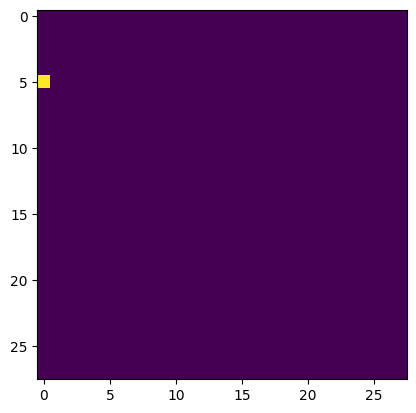

In [14]:
import matplotlib.pyplot as plt
plt.imshow(result[:, :, 13].numpy(), cmap='viridis')

### px

In [15]:
px.imshow(result[:, :, 13].numpy(),)

## Writing test

In [16]:
image = torch.zeros((28, 28, 28), dtype=torch.float32)
image[8, 8, 14] = 1
image = image.float()

max_idx = torch.nonzero(image == image.max())
print("Location(s) of maximum value in image:", max_idx)

result = shift_then_rotate_image_3d(
    image=image,
    rotate_xyz=[0, 0, 90],
    shifts_xyz=[0, 5, 0],
    interpolation="trilinear",
)
max_idx = torch.nonzero(result == result.max())
print("Location(s) of maximum value in result:", max_idx.tolist()[0],)
px.imshow(result[:, :, 14].numpy() + image[:,:,14].numpy() * 0.25, origin='lower')

Location(s) of maximum value in image: tensor([[ 8,  8, 14]])
Location(s) of maximum value in result: [13, 20, 14]


In [17]:
float(result[13,20,14])

1.0

In [18]:
assert image[19, 20, 14] == 0
assert torch.allclose(result[13,20,14], torch.tensor(1.0), atol=1e-6)
assert result[8, 14, 14] == 0

### Reviewing 2d tests

In [19]:
image_2d = torch.zeros((28, 28), dtype=torch.float32)
image_2d[18, 14] = 1
image_2d = image_2d.float()

result_2d = rotate_then_shift_image_2d(
    image=image_2d,
    rotate=0,
    shift=[2, 0],
    interpolation="bicubic",
)

# sanity check, array center which was 4 voxels below the dot should now be 1
# assert image[12, 12] == 0
# assert result[16, 10] == 1
# assert result[18, 14] == 0
print(image_2d[20,14])
print(image_2d[18,14])
print(result_2d[20,14])
px.imshow(result_2d + image_2d * 0.25, origin='lower', color_continuous_scale='gray')

tensor(0.)
tensor(1.)
tensor(1.)


### Trying with JE's pic

In [20]:
import pooch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

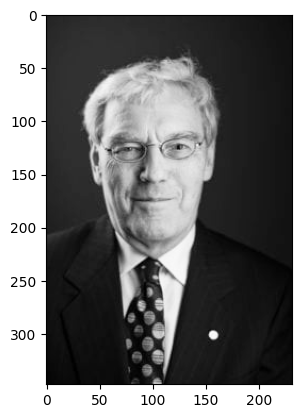

In [21]:
henderson_file = pooch.retrieve("https://www.nobelprize.org/images/henderson-15230-portrait-mini.jpg", known_hash=None)
henderson = Image.open(henderson_file)
henderson = henderson.convert('L')
henderson = np.array(henderson)
henderson_tensor = torch.tensor(henderson, dtype=torch.float32, device="cpu")
plt.imshow(henderson_tensor.cpu(),cmap="Greys_r")

In [25]:
henderson_3d = torch.as_tensor([henderson, henderson], dtype=torch.float32, device="cpu")
henderson_3d.shape

torch.Size([2, 348, 232])

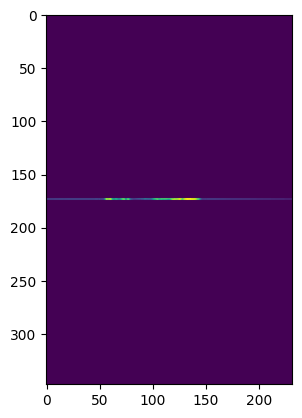

In [ ]:
result = shift_then_rotate_image_3d(
    image = henderson_3d,
    rotate_xyz=[0, 0, 0],
    shifts_xyz=[1, 0, 0],
)
plt.imshow(result[1, :, :])